In [127]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [151]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 'full'
pdgId = 13
category = 0
v1 = 'V1p15'
v2 = '/v1/v1'

if data_year == 2016:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data'+str(data_year)+v2+'/normalized/'
elif data_year == 2017:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data'+str(data_year)+v2+'/normalized/'
elif data_year == 2018:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data'+str(data_year)+v2+'/normalized/'
elif data_year == 'full':
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data2018/'+v2+'/normalized/'

else:
    print("DATA YEAR IS WRONG")
    raise NameError('DATA YEAR IS WRONG')
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v4/normalized/'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p14/MC_RunIIFall18/v4/v4/normalized/'



if category == 0:
    if data_year == 2016:
        fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
        fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'
        lumi = (5.632467289+2.572903489+1.685313225+3.988453305+3.068943620+3.527270568+8.609721915)*1000 #29.085073411
    elif data_year == 2017:
        fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
        fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'
        lumi = (4.738190514+4.145487893+ 9.295575564+2.603562425) * 1000 #20.782816396
 
    elif data_year == 2018:
        fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'

        fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
        lumi = (13.954129666 + 6.941561868 + 3.227904890 + 31.312400879) * 1000 #55.435997303
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018AB-HighMET-17Sep2018_goodLumi.root'
#         lumi = (13.954129666 + 6.941561868 ) * 1000 #AB
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018CD-HighMET-17Sep2018_goodLumi.root'
#         lumi = (3.227904890 + 31.312400879) * 1000 #CD
    else: #2016, 2017, 2018AB
        fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'
        fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

        lumi = (29.085073411 + 20.782816396+55.435997303)* 1000
        lumi = 137000


elif category == 1:
    fpath_bkg['mc'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v3/v5/normalized/WH_HToSSTobbbb_ms55_pl10000_1pb_weighted.root'

#     if pdgId == 13:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_SingleMuon_17Sept2018_Run2018D-ZMu-PromptReco-v2.root'
#     else:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_EGamma_17Sept2018_Run2018D-ZElectron-PromptReco-v2.root'
    lumi = 31.34*1000
else:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/v2/v3/normalized/'
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIISummer16/v1/v2/signals/normalized/'
    fpath_bkg['mc'] = mc_path + 'ZH_HToSSTobbbb_ms55_pl1000_1pb_weighted.root'
    fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_SingleMuon_17Sept2018_Run2018D-ZMu-PromptReco-v2_goodLumi.root'
    lumi = 29.516263349*1000

NEvents = {}
print(data_year, lumi/1000)
NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    NEvents_genweight[k] = root_dir['NEvents_genweight'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print("NEvents_genweight",NEvents_genweight[k])


    print ('weights',np.unique(a)*lumi)
    print(np.sum(a))
    print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)

full 137.0
mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v4/normalized/ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root
NEvents 520800.0
NEvents_genweight 11183702.0
weights [-12.91112723  12.65419545  12.78201591  12.91112723]
0.3858486
4107
data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/Data2018//v1/v1/normalized/Run2_displacedJetMuonNtupler_V1p15_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22716448.0
NEvents_genweight 0.0
weights [137000.]
20993308.0
20993309
6.136630296707153


# Load trigger

In [152]:
trigger_names_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:

trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]
xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# load bdt

In [153]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
# model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2'
# model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
model = pickle.load(open( bdt_name+'.pickle', "rb" ))


y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
# print (y_pred)
# y_pred_train = model.predict_proba(x_train)[:, 1]
# y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))


In [154]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# nCsc with different hit vetoing

In [156]:
%%time

start_t = time.time()
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False


# BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
# bdtBkgEff =  0.0661076084960519

# BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
# bdtBkgEff =  0.10278372591006424
if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
    BDT_CUT = 0.92245656 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs
    bdtBkgEff = 0.09957173447537473
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
    BDT_CUT = 0.9608465 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.06745182012847965
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2':
    BDT_CUT = 0.7802247 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.061027837259100645
else:
    print('BDT NAME NOT FOUND')

intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}

cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}

cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}

legend = {}

legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'

# keys = ['data','mc_intime_bkg','mc_oot_bkg','mc_signal']
keys = ['data_intime','data_oot','mc_signal','mc_bkg']
keys = ['data_intime','mc_signal',]
keys = ['data_intime','mc_signal']
keys = ['data_oot_vr','data_oot_sr', 'data_intime_vr', 'data_intime_sr', 'mc_vr','mc_sr']
# keys = ['data_oot_vr','data_oot_sr', 'data_intime_vr', 'data_intime_sr']
keys = ['data_oot', 'data_intime', 'mc']

for k in keys:
    print(k)
#     if k == 'data_intime': continue
    if k == 'mc_bkg':
        T = tree_bkg['QCDHT50toInf']
    elif k[:2] == 'mc':
        T = tree_bkg['mc']
    else:
        T = tree_bkg['data']

        
########### SELECTION: CLUSTERS ############

    sel_rechitcluster =  np.abs(T.array('cscRechitClusterMaxChamber')) > 12
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitClusterEta')) < 2.1)

    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberMinus12') <= me1112_veto)
    np.set_printoptions(threshold=10000)
    print("rechit cluster", np.count_nonzero(sel_rechitcluster.flatten()))
    if 'oot' in k:
        sel_rechitcluster = np.logical_and(sel_rechitcluster,  T.array('cscRechitClusterTime') < -12.5)
    else:
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterJetVetoPt') < JET_PT_CUT)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMuonVetoPt') < MUON_PT_CUT)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitClusterTime') < 12.5, T.array('cscRechitClusterTime') > -5.0))

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev[k] = np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev[k] = np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev[k]   = np.logical_or(sel_ev[k] ,hlt[:,tr])
        print("trigger",tr,1.0*np.count_nonzero(hlt[:,tr])/len(hlt[:,tr]))
    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == category)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)

    if category == 0:
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
        sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
        if k[:4] == 'data':
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_HBHENoiseFilter'))
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_HBHEIsoNoiseFilter'))# same as flag
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_BadPFMuonFilter'))# same as flag
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_globalSuperTightHalo2016Filter'))# same as flag
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_eeBadScFilter'))# same as flag

#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_ecalBadCalibFilter'))
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_EcalDeadCellTriggerPrimitiveFilter'))

            # missing Flag_EcalDeadCellTriggerPrimitiveFilter
#             ecalBadCalibReducedMINIAODFilter
#         elif k [:2] == 'mc':
#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_HBHENoiseFilter'))
#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_HBHEIsoNoiseFilter'))
#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_BadPFMuonFilter'))
#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_globalSuperTightHalo2016Filter'))
# #             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_eeBadScFilter'))
#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_ecalBadCalibFilter'))
#             sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_EcalDeadCellTriggerPrimitiveFilter'))

            

#             sel_ev = np.logical_and(sel_ev, T.array('runNum')<319077)
#             print('selev',np.count_nonzero(sel_ev))
#             sel_ev = np.logical_and(sel_ev, T.array('Flag_ecalBadCalibFilter'))
#             print('selev',np.count_nonzero(T.array('Flag_ecalBadCalibFilter')))
    print("here")
    gLLP_csc[k] = T.array('gLLP_csc')
    if k[:2] == 'mc':
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)
########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]

    print("here")
    ##### bdt variables ####
    
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEtaSpread[k] = T.array('cscRechitClusterEtaSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterPhiSpread[k] = T.array('cscRechitClusterPhiSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
        
        bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
         'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
         'cscRechitClusterNStation':cscRechitClusterNStation[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterX':cscRechitClusterX[k],
         'cscRechitClusterY':cscRechitClusterY[k],
         'cscRechitClusterZ':cscRechitClusterZ[k],
        }
    elif 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi' in bdt_name:
        bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
         'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
         'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterPhi':cscRechitClusterPhi[k],
         'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
         'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }
    else:
        print('BDT NAME NOT FOUND')
    
    print("here")
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev[k]))
    bdt_sel[k] = bdt_score[k] >= 0 
    if 'vr' in k:
        bdt_sel[k] = bdt_score[k] < BDT_CUT 
    else:
        bdt_sel[k] = bdt_score[k] >= BDT_CUT 
    print("effiency",np.count_nonzero(bdt_sel[k])/len(bdt_sel[k]))



    dphiMet_cluster[k] = np.abs(T.array('cscRechitClusterMet_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]

    jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev[k]][bdt_sel[k]]
    metPhi[k] = T.array('metPhi')[sel_ev[k]]
    jetPhi[k] = T.array('jetPhi')[sel_ev[k]]
    jetPt[k] = T.array('jetPt')[sel_ev[k]]
    jetMet_dPhiMin30[k] = []
    for ev in range(len(jetPhi[k])):
        dphi_min_temp = 999
        for i in range(len(jetPhi[k][ev])):
            if jetPt[k][ev][i] < 30: continue
            dphi_temp = abs(deltaPhi(metPhi[k][ev],jetPhi[k][ev][i]))
            if dphi_min_temp > dphi_temp: dphi_min_temp = dphi_temp
        jetMet_dPhiMin30[k].append(dphi_min_temp)
    jetMet_dPhiMin30[k] = np.array(jetMet_dPhiMin30[k])
    jetMet_dPhiMin30_sr[k] = jetMet_dPhiMin30[k][np.logical_not(bdt_sel[k])]
    jetMet_dPhiMin30[k] = jetMet_dPhiMin30[k][bdt_sel[k]]
    weight[k] = T.array('weight')[sel_ev[k]][bdt_sel[k]]
    npv[k] = T.array('npv')[sel_ev[k]][bdt_sel[k]]
    metPhi[k] = np.abs(metPhi[k][bdt_sel[k]])
    jetPhi[k] = np.abs(jetPhi[k][bdt_sel[k]])[:,0]
    cscRechitClusterPhi[k] = np.abs(cscRechitClusterPhi[k][bdt_sel[k]])

    if k[:2] == 'mc':
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][bdt_sel[k]]
    else:
        pileupWeight[k] = np.ones(weight[k].shape, dtype=bool)
    if k[:2] == 'mc':
        weight[k] = weight[k]*lumi
    ##### clusters #####
    cscClusterTime[k] = T.array('cscRechitClusterTime')[sel_rechitcluster][sel_ev[k]][bdt_sel[k]][:,0]
    cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev[k]][bdt_sel[k]]
    nRechits_sr[k] =  T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev[k]][np.logical_not(bdt_sel[k])]

    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
   
    br = 1
    var = jetMet_dPhiMin30[k]
    print(br)
    print("using dPhi(jet,met)")
    DPHI_CUT = 0.6
    a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
    b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT)])
    c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT)])
    d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
    print(a[k],b[k],c[k],d[k])
    print(b[k]/c[k]*d[k],a[k])
    print("uncertainty on a: ", (1./b[k] + 1./c[k] + 1./d[k])**0.5*(b[k]/c[k]*d[k]))
    if k == 'mc_sr':
        sig_dphiJet = a[k]
    elif k == 'data_intime_vr':
        bkg_dphiJet = a[k]/(1-bdtBkgEff)*bdtBkgEff
    var = dphiMet_cluster[k]
    DPHI_CUT = 0.75
    a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
    b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT)])
    c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT)])
    d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
    if k == 'mc_sr':
        sig_dphiCluster = d[k]
    elif k == 'data_intime_vr':
        bkg_dphiCluster = a[k]/(1-bdtBkgEff)*bdtBkgEff
    
#     if k == 'data_intime':
#         print(np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<70]/(1-bdtBkgEff)*bdtBkgEff))
#         print(np.count_nonzero(nRechits_SR[k]<70))
    

# print("branching ratio: "+str(br))
# print(sig_dphiJet*137000/lumi, bkg_dphiJet*137000/lumi)
# print(sig_dphiCluster*137000/lumi, bkg_dphiCluster*137000/lumi)

# br = 0.005
# print("branching ratio: "+str(br))
# print("asimov dataset")
# s = br*sig_dphiJet*137000/lumi
# b = bkg_dphiJet* 137000/lumi
# sig = (2*(s+b)*math.log(1+s/b)-s)**0.5
# print("significance for dPhi(jet, MET): ", sig)
# s = br*sig_dphiCluster*137000/lumi
# b = bkg_dphiCluster* 137000/lumi
# sig = (2*(s+b)*math.log(1+s/b)-s)**0.5
# print("significance for dPhi(cluster,MET): ", sig)


data_oot
rechit cluster 118192
trigger 310 0.7416220091839738
here
here
here
True
effiency 0.027835768963117607
1
using dPhi(jet,met)
9.0 34.0 61.0 16.0
8.918032786885245 9.0
uncertainty on a:  2.9349028752947657
data_intime
rechit cluster 118192
trigger 310 0.7416220091839738
here
here
here
True
effiency 0.05643879173290938
1
using dPhi(jet,met)
9.0 21.0 33.0 8.0
5.090909090909091 9.0
uncertainty on a:  2.2932953595886953
mc
rechit cluster 313
trigger 310 0.9498417336255174
here
here
here
True
effiency 0.9368421052631579
1
using dPhi(jet,met)
1833.2509557149024 219.4891629551421 0.0 219.4891629551421
inf 1833.2509557149024
uncertainty on a:  inf
CPU times: user 4min 3s, sys: 55 s, total: 4min 58s
Wall time: 4min 53s


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:296: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:297: RuntimeWarning: divide by zero encountered in double_scalars


# correlation between the two ABCD variables

In [133]:
k = 'data_intime_vr'
print(scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin30[k]))
print(scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k]))


k = 'data_oot_sr'
print(scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin30[k]))
print(scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k]))


k = 'data_oot_vr'
print(scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin30[k]))
print(scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k]))
# print(len(jetMet_dPhiMin30['data_intime_vr'])/len(jetMet_dPhiMin30['data_oot_sr']))

(0.08794569598467653, 0.2555326809290894)
(-0.13800175824123181, 0.07356987823878795)
(-0.1408039211481737, 0.3925610200185523)
(-0.1045988854846134, 0.5262707010000146)
(-0.056901146717823106, 0.17953319511774501)
(-0.030858901624875663, 0.4669268609542585)


# ABCD

In [149]:
a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(90,220,10)
# cuts = np.arange(90,150,1)

# cuts = [90,95,100,104,105]
print(cuts)
bkg_dphiJet = []
sig_dphiJet = []
bkg_dphiCluster = []
sig_dphiCluster = []
print_jetmet = 0
for N_RECHIT_CUT in cuts:
    for k in keys:
        if not k == 'data_oot_vr': continue
        var = np.abs(jetMet_dPhiMin30[k])
#         var = 
        br = 1
        DPHI_CUT = 0.6
#         br = np.sum(weight['data_intime'])/np.sum(weight['data_oot'])
        br = 1
        a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT)])
        c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
#         cut = 90
#         a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT))])
#         b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT))])
#         c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT))])
#         d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT))])
        if not k == 'mc_signal' and print_jetmet:
#             print("using dPhi(jet,met) with N_RECHIT CUT", N_RECHIT_CUT)
#             print("A B C D prediction, unc of prediction")
            print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k], '\t',round(b[k]/c[k]*d[k], 2),
                  '\t', round((1./b[k] + 1./c[k] + 1./d[k])**0.5*(b[k]/c[k]*d[k]), 2))
#             print(b[k]/c[k]*d[k],a[k])
#             print("uncertainty on a: ", (1./b[k] + 1./c[k] + 1./d[k])**0.5*(b[k]/c[k]*d[k]))
        if k == 'mc_signal':
            sig_dphiJet.append(a[k]*137000/lumi)
#             print(sig_dphiJet[-1]/137000*lumi)
        elif k == 'data_intime':
    #         bkg_dphiJet = b[k]/c[k]*d[k]
#             bkg_dphiJet.append(a[k]/(1-bdtBkgEff)*bdtBkgEff*137000/lumi)
            bkg_dphiJet.append(b[k]/c[k]*d[k]/(1-bdtBkgEff)*bdtBkgEff*137000/lumi)

        var = dphiMet_cluster[k]
        DPHI_CUT = 0.75
        a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT)])
        c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)])

        if not k == 'mc_signal' and not print_jetmet:
#             print("using dPhi(cluster,met) with N_RECHIT CUT", N_RECHIT_CUT)
#             print("A B C D prediction, unc of prediction")
            print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(c[k]/b[k]*a[k], 2), '\t',round( (1./c[k] + 1./b[k] + 1./a[k])**0.5*(c[k]/b[k]*a[k]), 2))
#             print(c[k]/b[k]*a[k],d[k])
# #             print("uncertainty on d: ", (1./c[k] + 1./b[k] + 1./a[k])**0.5*(c[k]/b[k]*a[k]))
        if k == 'mc_signal':
            sig_dphiCluster.append(d[k]*137000/lumi)
#             print(sig_dphiCluster[-1]/137000*lumi)
        elif k == 'data_intime':
    #         bkg_dphiCluster = c[k]/b[k]*a[k]
#             bkg_dphiCluster.append(d[k]/(1-bdtBkgEff)*bdtBkgEff*137000/lumi)
            bkg_dphiCluster.append(c[k]/b[k]*a[k]/(1-bdtBkgEff)*bdtBkgEff*137000/lumi)
bkg_dphiJet = np.array(bkg_dphiJet)
sig_dphiJet = np.array(sig_dphiJet)
bkg_dphiCluster = np.array(bkg_dphiCluster)
sig_dphiCluster = np.array(sig_dphiCluster)
print(sig_dphiJet)
print(sig_dphiCluster)


[ 90 100 110 120 130 140 150 160 170 180 190 200 210]
90 	 49.0 	 385.0 	 107.0 	 17.0 	 13.62 	 2.45
100 	 37.0 	 397.0 	 111.0 	 13.0 	 10.35 	 2.03
110 	 25.0 	 409.0 	 112.0 	 12.0 	 6.85 	 1.55
120 	 21.0 	 413.0 	 113.0 	 11.0 	 5.75 	 1.39
130 	 15.0 	 419.0 	 114.0 	 10.0 	 4.08 	 1.14
140 	 10.0 	 424.0 	 117.0 	 7.0 	 2.76 	 0.92
150 	 9.0 	 425.0 	 117.0 	 7.0 	 2.48 	 0.87
160 	 8.0 	 426.0 	 117.0 	 7.0 	 2.2 	 0.81
170 	 5.0 	 429.0 	 118.0 	 6.0 	 1.38 	 0.63
180 	 5.0 	 429.0 	 119.0 	 5.0 	 1.39 	 0.64
190 	 5.0 	 429.0 	 120.0 	 4.0 	 1.4 	 0.64
200 	 5.0 	 429.0 	 120.0 	 4.0 	 1.4 	 0.64
210 	 5.0 	 429.0 	 120.0 	 4.0 	 1.4 	 0.64
[]
[]


# significance optimization

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.2,0.7,0.60,0.94)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.02)
c = rt.TCanvas('c','c', 800, 800)


h = {}
rt.gStyle.SetOptFit(1011)

name = ['min_{4 jet} \Delta\Phi(jet,MET)','\Delta\Phi(cluster,MET)']
var_sig = [sig_dphiJet, sig_dphiCluster]
var_bkg = [bkg_dphiJet, bkg_dphiCluster]
br = 0.003
# print(cuts)
# print(b)

for i in range(len(var_sig)):
    s = br* var_sig[i]
    b = var_bkg[i]

    asimov = (2*(s+b)*np.log(1+s/b)-s)**0.5
    punzi =  s/(3/2.+b**0.5)
    s_over_b = s/(s+b)**0.5
#     print(s_over_b)
#     print(asimov)
#     print(punzi)
    h['asimov'+str(i)] = create_TGraph(cuts, asimov,  axis_title=['N_{rechits} cut', 'Significance'])
    h['punzi'+str(i)] = create_TGraph(cuts, punzi,  axis_title=['N_{rechits} cut', 'Significance'])
    h['s_over_b'+str(i)] = create_TGraph(cuts, s_over_b,  axis_title=['N_{rechits} cut', 'Significance'])

    leg.AddEntry(h['asimov'+str(i)], name[i])
#     leg.AddEntry(h['punzi'+str(i)], name[i]+' Punzi')
#     leg.AddEntry(h['s_over_b'+str(i)], name[i]+' s/\sqrt{s+b}')
    
    h['asimov'+str(i)].SetLineWidth(2)
    h['punzi'+str(i)].SetLineWidth(2)
    h['s_over_b'+str(i)].SetLineWidth(2)
    
    h['asimov'+str(i)].SetLineColor(std_color_list[0])
    h['punzi'+str(i)].SetLineColor(std_color_list[1])
    h['s_over_b'+str(i)].SetLineColor(std_color_list[2])
    
    if i == 0:
#         h['asimov'+str(i)].SetLineStyle(2)
#         h['punzi'+str(i)].SetLineStyle(2)
#         h['s_over_b'+str(i)].SetLineStyle(2)
        h['asimov'+str(i)].SetLineColor(std_color_list[1])
#     h['punzi'+str(i)].Draw('ac' if i == 0 else 'c')
#     h['s_over_b'+str(i)].Draw('c')
    h['asimov'+str(i)].Draw('ac' if i == 0 else 'c')

#     h['s_over_b'+str(i)].GetYaxis().SetRangeUser(0.0, 10.0)
    h['asimov'+str(i)].GetYaxis().SetRangeUser(2.0, 10.0)
    print(name[i], cuts[np.argmax(asimov)], cuts[np.argmax(punzi)], cuts[np.argmax(s_over_b)])
    
#     h['s_over_b'+str(i)].GetYaxis().SetLimits(0.0, 10.0)

#     h[str(i)].GetXaxis().SetLabelSize(0.04)
    
c.SetRightMargin(0)
# c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

# background prediction

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.2,0.7,0.60,0.94)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.02)
c = rt.TCanvas('c','c', 800, 800)


h = {}
rt.gStyle.SetOptFit(1011)

name = ['min_{4 jet} \Delta\Phi(jet,MET)','\Delta\Phi(cluster,MET)']
var_sig = [sig_dphiJet, sig_dphiCluster]
var_bkg = [bkg_dphiJet, bkg_dphiCluster]
br = 0.003

for i in range(len(var_sig)):
    s = br* var_sig[i]
    b = var_bkg[i]
    asimov = (2*(s+b)*np.log(1+s/b)-s)**0.5
    punzi =  s/(3/2.+b**0.5)
    s_over_b = s/(s+b)**0.5

    h['asimov'+str(i)] = create_TGraph(cuts, asimov,  axis_title=['N_{rechits} cut', 'Significance'])
    h['punzi'+str(i)] = create_TGraph(cuts, punzi,  axis_title=['N_{rechits} cut', 'Significance'])
    h['s_over_b'+str(i)] = create_TGraph(cuts, s_over_b,  axis_title=['N_{rechits} cut', 'Significance'])
    h['sig'+str(i)] = create_TGraph(cuts, s,  axis_title=['N_{rechits} cut', 'Events'])
    h['bkg'+str(i)] = create_TGraph(cuts, b,  axis_title=['N_{rechits} cut', 'Events'])

    leg.AddEntry(h['sig'+str(i)], name[i]+' Signal')
    leg.AddEntry(h['bkg'+str(i)], name[i]+' Background')
    
    h['sig'+str(i)].SetLineWidth(2)
    h['bkg'+str(i)].SetLineWidth(2)
    
    h['bkg'+str(i)].SetLineColor(std_color_list[0])
    h['sig'+str(i)].SetLineColor(std_color_list[1])

    if i == 0:
        h['sig'+str(i)].SetLineStyle(2)
        h['bkg'+str(i)].SetLineStyle(2)

#     h['punzi'+str(i)].Draw('ac' if i == 0 else 'c')
#     h['s_over_b'+str(i)].Draw('c')
#     h['asimov'+str(i)].Draw('c')
    h['sig'+str(i)].Draw('ac' if i == 0 else 'c')
    h['bkg'+str(i)].Draw('c')
#     h['s_over_b'+str(i)].GetYaxis().SetRangeUser(0.0, 10.0)
    h['sig'+str(i)].GetYaxis().SetRangeUser(0.0, 15.0)

    
c.SetRightMargin(0)
# c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

# create datacard

# check correlation

In [ ]:
k = 'data_intime'
cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= 200
print(np.count_nonzero(cond))
print(k, 'correlation between n_rechits and deltaphi',scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], jetMet_dPhiMin4[k][cond])[0])
print(k, 'correlation between n_rechits and deltaphi',scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], dphiMet_cluster[k][cond])[0])

In [ ]:
k = 'data_intime'
print(cscRechitClusterMet_dPhi[k])
print(dphiMet_cluster[k])

## Distribution for event level variables in different binnings

50 90 , 29 11 18
90 2000 , 10 5 5
50 90 , 29 11 18
90 2000 , 10 5 5
50 90 , 29 11 18
90 2000 , 10 5 5
50 90 , 29 11 18
90 2000 , 10 5 5
50 90 , 29 11 18
90 2000 , 10 5 5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_oot_sr (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_data_oot_sr_2016_cscRechitClusterPhi.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_oot_sr (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_data_oot_sr_2016_metPhi.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_oot_sr (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_data_oot_sr_201

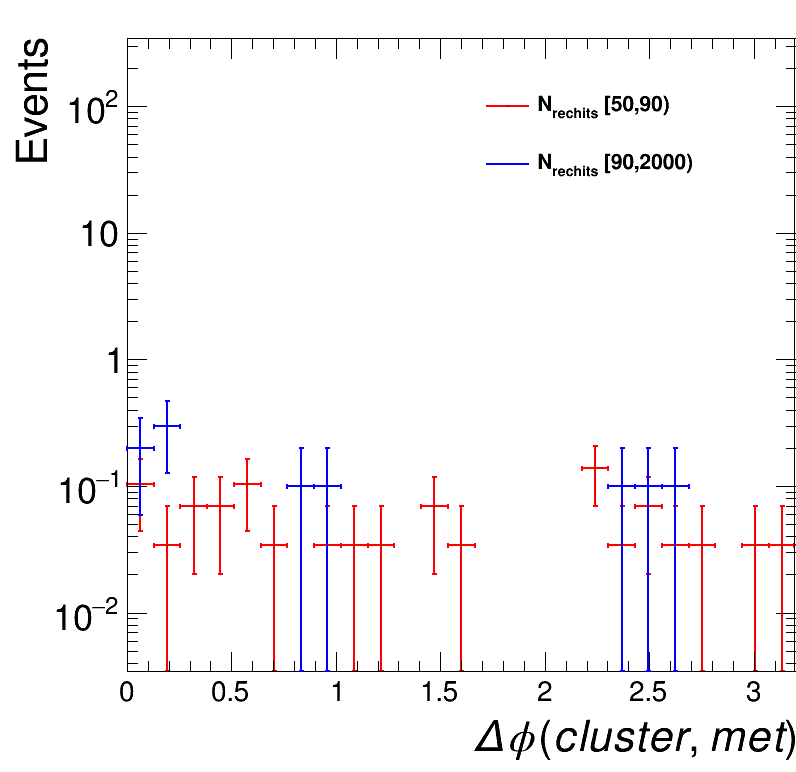

In [126]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


br = 1
k = 'data_oot_sr'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50,90, 2000]
var = [cscRechitClusterPhi, metPhi, jetPhi, jetMet_dPhiMin30, dphiMet_cluster]
varName = ['cscRechitClusterPhi', 'metPhi', 'jetPhi', 'jetMet_dPhiMin30', 'dphiMet_cluster']
xaxis = ['abs(csc cluster \phi)', 'abs(MET \phi)', 'leading jet #phi', 'min \Delta \phi(MET,jet)', '\Delta \phi(cluster,met)']
for j,v in enumerate(var):
#     if not j == 2:continue
    leg = rt.TLegend(0.6,0.75,0.90,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    rt.gStyle.SetOptFit(1011)
    maxb = 0
    for i,cut in enumerate(cuts):

        metcut = 200
        if i == 0:
            previous_cut = cut

            continue
            cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] <= cut
    #         cond = angle[k]<=cut
        else:
            cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= previous_cut)
    #         cond = np.logical_and(angle[k] <= cut, angle[k] > previous_cut)

    #     h[k] = create_TH1D( nLeptons[k][cond], axis_title=['N_{lep}', 'Events'], name=k, binning=bins)

    #     h[str(i)] = create_TH1D( jetPt[k].count()[cond], axis_title=['N_{jets}', 'Events'], name=k, binning=[15,0,15])
    #     h[str(i)] = create_TH1D( jetPt[k][np.logical_and(cond, jetPt[k].count()>0)][:,0], axis_title=['jet p_{T} [GeV]', 'Events'], name=k, binning=[50,0,2500],weights = weight[k][[np.logical_and(cond, jetPt[k].count()>0)]])
    #     h[str(i)] = create_TH1D( cscRechitClusterEta[k][cond], axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,-3.2,3.2])
#         print(np.count_nonzero(bdt_sel[k]))
#         print(len(cond))
#         variable = v[k][bdt_sel[k]]
        h[str(i)] = create_TH1D( v[k][cond], axis_title=[xaxis[j], 'Events'], name=k, binning=[25,0,3.2])

#         h[str(i)] = create_TH1D( np.abs(cscRechitClusterPhi[k][bdt_sel[k]][cond]), axis_title=['abs(csc cluster \phi)', 'Events'], name=k, binning=[25,0,3.2])
#         h[str(i)] = create_TH1D( np.abs(metPhi[k][bdt_sel[k]][cond]), axis_title=['abs(MET \phi)', 'Events'], name=k, binning=[25,0,3.2])
#         h[str(i)] = create_TH1D( dphiMet_cluster[k][cond], axis_title=['\Delta \phi(cluster,met)', 'Events'], name=k, binning=[25,0,3.2])
#         h[str(i)] = create_TH1D( np.abs(jetPhi[k][bdt_sel[k]][cond][:,0]), axis_title=['leading jet #phi', 'Events'], name=k, binning=[25,0, 3.2])

#         h[str(i)] = create_TH1D( jetMet_dPhiMin30[k][cond], axis_title=['min \Delta \phi(MET,jet)', 'Events'], name=k, binning=[25,0,3.2])
#         h[str(i)].SetLineColor(std_color_list[i-1])
        print(previous_cut, cut, "," ,len(jetMet_dPhiMin30[k][cond]), np.count_nonzero(jetMet_dPhiMin30[k][cond]>=0.6), np.count_nonzero(jetMet_dPhiMin30[k][cond]<0.6))

        leg.AddEntry(h[str(i)], name+" [%(first)d,%(second)d)"%{"first":previous_cut,"second":cut})

    #     leg.AddEntry(h[str(i)], "N_{rechits} in (%(first)d,%(second)d]"%{"first":previous_cut,"second":cut})
        previous_cut = cut

    #     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])*br)
#         if i == len(cuts)-1:
        h[str(i)].SetMaximum(10E3)
        h[str(i)].SetMinimum(0.1)



    #     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
    #     print(r.Get())
    #     print(r.Prob())
    #     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
    #     h[k].GetFunction("expo").SetLineWidth(2)
        h[str(i)].GetXaxis().SetLabelSize(0.04)
        h[str(i)].SetLineColor(std_color_list[i])
        h[str(i)].DrawNormalized('same E1')


    c.SetRightMargin(0)
    c.SetLogy()
    leg.Draw()
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/abcdVar/v1p15_'+k+'_'+str(data_year)+'_'+varName[j]+'.png')
    c.Draw()
# print(time.time()-start_t)

# Roc curve for event level variables

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.2,0.75,0.50,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
k = 'data_intime'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50,80,150,2000]
h = create_TH1D( np.abs(cscRechitClusterEta[k][dphiMet_cluster[k]<0.5]), axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,0,2.5])
h2 = create_TH1D( np.abs(cscRechitClusterEta[k]), axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,0,2.5])
leg.AddEntry(h,"dphi(met, cluster) < 0.5")
leg.AddEntry(h2,"inclusive")

h.SetLineColor(std_color_list[0])
h2.SetLineColor(std_color_list[1])

h.DrawNormalized('same E1')
h2.DrawNormalized('same E1')


c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

In [ ]:
np.arange(3.0,7.0,0.1)

# Data plot

In [157]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'




keys = ['data_intime','data_oot','mc_signal',]
keys = ['data_intime','mc_signal',]
# keys = ['data_intime','mc_signal',]
keys = ['data_oot_vr','data_oot_sr', 'data_intime_vr', 'data_intime_sr']
keys = ['data_intime','data_oot','mc',]


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
for i,k in enumerate(keys):

#     if k == 'data_intime':
#         cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < 200
        
#     else:
#         cond = np.ones(weight[k].shape, dtype=bool)
#     cond = np.logical_and(cond, jetMet_dPhiMin4[k]>0.25)
    if k == 'mc_signal':
        br = 1
    else: br = 1
#     if k == 'mc_background':br = 1
    bins = [50,0,1000]
    metcut = 200
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['N_{rechits}', 'Events'], name=k, binning=bins,weights = br*weight[k][cond])
    h[k].SetLineColor(std_color_list[i])
    print("weight",weight[k][0])
    leg.AddEntry(h[k], legend[k]+" (scaled)" if k == 'data_oot' else legend[k])
#     if k == 'mc_signal':
#         for i in range(h[k].GetNbinsX()):
#             s = 0.015*h[k].GetBinContent(i+1)
#             b = h['data_oot'].GetBinContent(i+1)
#             if s+b == 0:continue
#             sig = s/(s+b)**0.5
#             print(i,h[k].GetBinCenter(i+1),sig,s,b)
#             if sig < 1./100:
#                 print(i,sig)
#                 continue
#     h[k].SetMinimum(1)

#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].SetMinimum(0.1)
    h[k].SetMaximum(10E6/2)
#     h[k+'met'].GetXaxis().SetLabelSize(0.02)
    if k == 'data_oot':
        scale = 1.0*h['data_intime'].GetBinContent(4)/h['data_oot'].GetBinContent(4)
#         for i in range(10):
#             print(1.0*h['data_intime'].GetBinContent(i+1)/h['data_oot'].GetBinContent(i+1))
        h[k].Scale(scale)
    if k[:4] == 'data':
        h[k].Draw('same E1')
    else:
        h[k].Draw("same hist")
#     h[k+'met'].DrawNormalized('same')
    

# c = make_ratio_plot([h['mc'],h['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 39

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()


k = 'data_intime'

h = {}
rt.gStyle.SetOptFit(1011)

bins = [40,0,1000]
metcut = 200

# cscRechitClusterMaxChamber = {}
# cscRechitClusterNChamber = {}
# cscRechitClusterNStation = {}
# cscRechitClusterMaxStationRatio = {}
# cscRechitClusterMaxChamberRatio = {}

# h[k] = create_TH1D( cscRechitClusterMaxChamber[k], axis_title=['max chamber', 'Events'], name=k, binning=[200,-50,50])
h[k] = create_TH1D( cscRechitClusterMaxChamberRatio[k], axis_title=['max chamber ratio', 'Events'], name=k, binning=[20,0,1])
# h[k] = create_TH1D( cscClusterMet_dPhi[k], axis_title=['#Delta#phi(MET, cluster)', 'Events'], name=k, binning=[20,0,3.14])
# h[k] = create_TH1D( n_chamber[k], axis_title=['Number of Chambers', 'Events'], name=k, binning=[10,0,10])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['max station', 'Events'], name=k, binning=[5,0,5])
# print(cscRechitClusterMaxStationRatio[k])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['Number of station', 'Events'], name=k, binning=[20,0,10])


# h['1jet'].GetXaxis().SetLabelSize(0.04)
# h['1jet'].SetMinimum(0.1)
# h['1jet'].SetMaximum(10E6/2)

h[k].Draw('hist')


c.SetRightMargin(0)
c.SetLogy()

c.Draw()
# print(time.time()-start_t)

## significance

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'data_oot'
sig_k = 'mc_signal'
br = 0.01

threshold = list(range(300))
threshold = np.array(list(range(2000)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in ['data_oot','mc_signal']:
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['N_{rechits}', 'Significnace'])
#     h[sig_k+str(i)] = create_TGraph(ncsc, event_count[sig_k],  axis_title=['N_{rechits}', 'Event Yield'])

    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 3000)
    h[sig_k+str(i)].GetXaxis().SetLabelSize(0.04)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# 2d plot

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin4[k])),
                   axis_title = ['N_{rechits}','min_{4jet}\Delta\phi (jet,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# third

# ROC Curve

# 4th

# nCsc histogram

# event yield vs. ncsc

# significance